# Generation of novel views from files .obj .mtl texture.png

Here from file **.obj** we generate a novel dataset to evaluate ours models with respect to the ground truth point cloud.



In [1]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
import math

Mounted at /content/drive


In [2]:
import shutil

In [44]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.13.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

import pytorch3d
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene

from pytorch3d.utils import ico_sphere
from pytorch3d.io import load_obj, load_objs_as_meshes 
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance


# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex, Textures
)
from pytorch3d.io import IO

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

# We will also create a Phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

### Read OBJ file

In [40]:
import pandas as pd
import subprocess
import shutil
import pickle
import glob

In [7]:
def runcmd(cmd, verbose = False, *args, **kwargs):
    process = subprocess.Popen(
        cmd,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text = True,
        shell = True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)
    pass

In [8]:
# Getting all the test classes 
test_csv = "https://shapenet.cs.stanford.edu/shapenet/obj-zip/SHREC16/all.csv"
runcmd(f"wget --no-check-certificate {test_csv}", verbose = False)

df = pd.read_csv("all.csv")
classes = df['synsetId'].unique()

In [9]:
print(len(classes))

55


In [84]:
distance = 2.8
txtless_objs = 0
num_views = 6
num_points = 4096
fixed_elevation = 2
angles = np.linspace(0,360,num_views)

n_test_classes = 25
num_objects_per_class = 25

PILToTensor = transforms.PILToTensor()

dataset_clouds = [] # N, v, w, h, c 
dataset_views_stochastic_elevation = [] # N, c, K
dataset_views_fixed_elevation = [] # N, c, K
test_classes = random.choices(list(classes), k = min(len(classes), n_test_classes))

for c in test_classes:
  filename = "{:08d}".format(int(c))

  # Download, extract and walk for this class
  print(f"[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/{filename}.zip")

  if not os.path.exists(f"{filename}.zip"):
    runcmd(f"wget --no-check-certificate https://shapenet.cs.stanford.edu/shapenet/obj-zip/{filename}.zip", verbose = False)
  assert os.path.exists(f"{filename}.zip") == True, f"Error in downloading the class {filename}"
  
  runcmd(f"unzip -o {filename}.zip", verbose = False)
  assert os.path.exists(filename) == True, f"Error in unzipping the class {filename}"
  
  # For each class: choose some models and save the renders
  # here we select only the folders in which the objects
  # are provided with the texture and the verts_packed
  folders = glob.glob(f'./{filename}/*/images')
  # select all the name of the folder with obj with texture
  folders = [folders[i].split('/')[2] for i in range(len(folders))]

  for folder in tqdm(random.choices(list(folders), k=min(len(folders),num_objects_per_class))):
      
    # Initialize for each object
    ground_views_stochastic_elevation = []
    ground_views_fixed_elevation = []
    pt_ground_views_stochastic_elevation = None
    pt_ground_views_fixed_elevation = None
    elevations = random.choices(list(range(90)), k=num_views)
    rendered = False

    try:
      #print(f'./{filename}/'+folder+'/model.obj')
      verts, faces, aux = load_obj(f'./{filename}/'+folder+'/model.obj', load_textures=True)

      # add a dimension
      verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
      faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)
      tex_maps = aux.texture_images

      # tex_maps is a dictionary of {material name: texture image}.
      # Take the first image:
      texture_image = list(tex_maps.values())[0]
      texture_image = texture_image[None, ...]  # (1, H, W, 3)

      # Create a textures object
      tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)

      # Initialise the mesh with textures
      mesh = Meshes(verts=[verts], faces=[faces.verts_idx], textures=tex).to(device)

      # make the scene centered in offset
      verts = mesh.verts_packed()
      N = verts.shape[0]
      center = verts.mean(0)
      scale = max((verts - center).abs().max(0)[0])
      mesh.offset_verts_(-center)
      mesh.scale_verts_((1.0 / float(scale)));

      #print('mesh loaded')

      for i in range(num_views):
        # render view
        R, T = look_at_view_transform(distance, elevations[i], angles[i], device=device)
        image_ref = phong_renderer(meshes_world=mesh, R=R, T=T)
        
        # channel 4 is the alpha channel
        pil_img = (image_ref.cpu().numpy().squeeze()[:,:,:3] * 255).astype(np.uint8)
        pt_img = torch.Tensor(image_ref.cpu().numpy().squeeze()[:,:,:3] * 255)
        
        # if pt_ground_views_stochastic_elevation is None: pt_ground_views_stochastic_elevation = pt_img.unsqueeze(0) 
        # else: pt_ground_views_stochastic_elevation = torch.cat((pt_ground_views_stochastic_elevation, pt_img.unsqueeze(0)), 0)

        ground_views_stochastic_elevation.append(Image.fromarray(pil_img))

      for i in range(num_views):
        # render view
        R, T = look_at_view_transform(distance, fixed_elevation , angles[i], device=device)
        image_ref = phong_renderer(meshes_world=mesh, R=R, T=T)
        
        # channel 4 is the alpha channel
        pil_img = (image_ref.cpu().numpy().squeeze()[:,:,:3] * 255).astype(np.uint8)
        pt_img = torch.Tensor(image_ref.cpu().numpy().squeeze()[:,:,:3] * 255)
        
        # if pt_ground_views_fixed_elevation is None: pt_ground_views_fixed_elevation = pt_img.unsqueeze(0) 
        # else: pt_ground_views_fixed_elevation = torch.cat((pt_ground_views_fixed_elevation, pt_img.unsqueeze(0)), 0)

        ground_views_fixed_elevation.append(Image.fromarray(pil_img))

        # Plot views
        """
        cols = 2
        rows = (num_views // cols)
        f, axarr = plt.subplots(rows, cols)
        for i in range(num_views):
            axarr[i // cols, i % cols].imshow(ground_views[i])
        plt.show()
        """
      #print('rendered = True')
      rendered = True
      
    except:
      # print("[!] Textureless object found")
      txtless_objs += 1

    # Save point cloud and views
    if rendered:
      pc = pytorch3d.ops.sample_points_from_meshes(mesh, num_points)[0].permute(1, 0)
      
      # export as a list
      dataset_views_stochastic_elevation.append(ground_views_stochastic_elevation)
      dataset_views_fixed_elevation.append(ground_views_fixed_elevation)
      dataset_clouds.append(pc)

      # if dataset_views_stochastic_elevation is None: dataset_views = pt_ground_views_stochastic_elevation.unsqueeze(0)
      # else: dataset_views_stochastic_elevation = torch.cat((dataset_views, pt_ground_views_stochastic_elevation.unsqueeze(0)), 0)

      # if dataset_views_fixed_elevation is None: dataset_views = pt_ground_views_fixed_elevation.unsqueeze(0)
      # else: dataset_views_fixed_elevation = torch.cat((dataset_views, pt_ground_views_fixed_elevation.unsqueeze(0)), 0)

      # if dataset_clouds is None: dataset_clouds = pc 
      # else: dataset_clouds = torch.cat((dataset_clouds, pc), 0)

  # # # # if you prefear to export as a tensor
  # torch.save(dataset_clouds, "eval_clouds.pt")
  # torch.save(dataset_views_stochastic_elevation, "eval_views_stochastic_elevation.pt")
  # torch.save(dataset_views_fixed_elevation, "eval_views_fixed_elevation.pt")

  # # make a checkpoint in the drive folder
  # runcmd("cp ./eval_clouds.pt /content/drive/MyDrive")
  # runcmd("cp ./eval_views_stochastic_elevation.pt /content/drive/MyDrive")
  # runcmd("cp ./eval_views_fixed_elevation.pt /content/drive/MyDrive")

  # save the file in the folder
  with open('./eval_clouds.pickle', 'wb') as handle:
      pickle.dump(dataset_clouds, handle, protocol=pickle.HIGHEST_PROTOCOL)
  with open('./eval_views_stochastic_elevation.pickle', 'wb') as handle:
      pickle.dump(dataset_views_stochastic_elevation, handle, protocol=pickle.HIGHEST_PROTOCOL)
  with open('./eval_views_fixed_elevation.pickle', 'wb') as handle:
      pickle.dump(dataset_views_fixed_elevation, handle, protocol=pickle.HIGHEST_PROTOCOL)

  # make a checkpoint in the drive folder
  runcmd("cp ./eval_clouds.pickle /content/drive/MyDrive")
  runcmd("cp ./eval_views_stochastic_elevation.pickle /content/drive/MyDrive")
  runcmd("cp ./eval_views_fixed_elevation.pickle /content/drive/MyDrive")

  # Cleanup
  runcmd(f"rm {filename}.zip", verbose = False)
  runcmd(f"rm -rf {filename}", verbose = False)

[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/04330267.zip


100%|██████████| 25/25 [00:11<00:00,  2.19it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/04090263.zip


100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/03593526.zip


100%|██████████| 25/25 [00:08<00:00,  2.84it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/04004475.zip


100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/02843684.zip


100%|██████████| 25/25 [00:06<00:00,  4.00it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/04099429.zip


100%|██████████| 25/25 [00:10<00:00,  2.30it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/04379243.zip


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/02876657.zip


100%|██████████| 25/25 [00:06<00:00,  3.74it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/02933112.zip


100%|██████████| 25/25 [00:08<00:00,  3.08it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/02992529.zip


100%|██████████| 25/25 [00:07<00:00,  3.48it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/03991062.zip


100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/02992529.zip


100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/03046257.zip


100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/04074963.zip


100%|██████████| 25/25 [00:08<00:00,  3.10it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/03797390.zip


100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/03636649.zip


100%|██████████| 25/25 [00:15<00:00,  1.61it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/03991062.zip


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/03759954.zip


100%|██████████| 25/25 [00:08<00:00,  2.88it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/03467517.zip


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/03710193.zip


100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/02773838.zip


100%|██████████| 25/25 [00:11<00:00,  2.12it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/03211117.zip


100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/04004475.zip


100%|██████████| 25/25 [00:11<00:00,  2.25it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/04530566.zip


100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


[-] Downloading for obj: https://shapenet.cs.stanford.edu/shapenet/obj-zip/03337140.zip


100%|██████████| 25/25 [00:14<00:00,  1.76it/s]


In [74]:
df

,id,synsetId,subSynsetId,modelId,split
0,772,2691156,2690373,521eab9363fdc2a07209009cfb89d4bd,test
1,1119,2691156,2690373,50da48c8e7644508fca1f1143bb6bc17,test
2,3325,2691156,2690373,43abe330362164e99be82ec29531a70f,test
3,4710,2691156,2690373,4ad92be763c2ded8fca1f1143bb6bc17,test
4,5357,2691156,2690373,d06105ee2a2ae27c51008e496c6cfd2e,test
...,...,...,...,...,...
51185,33646,4554684,4554684,e3c637980c8c22eaf4a3d771dd0a0ffa,val
51186,36894,4554684,4554684,933dc825712acc8ab5a3b8119a3da34a,val
51187,45769,4554684,4554684,8f9232a493ccf77e46cde67a6a1ea328,val
51188,49697,4554684,4554684,5517868119f44388a027ae047c88a1b9,val


In [86]:
print('number of different objects in the dataset: ',len(dataset_views_fixed_elevation))

number of different objects in the dataset:  625


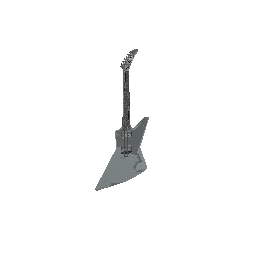

In [81]:
dataset_views_fixed_elevation[3][1]

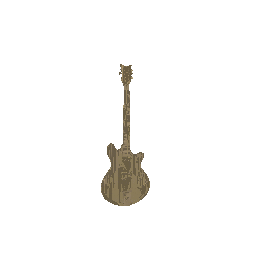

In [83]:
dataset_views_fixed_elevation[0][1]

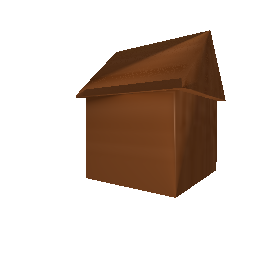

In [96]:
dataset_views_fixed_elevation[100][3]

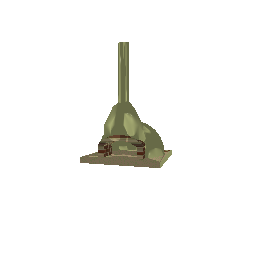

In [103]:
dataset_views_fixed_elevation[12][4]

--2023-02-12 15:12:52--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.1’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-02-12 15:12:52 (29.6 MB/s) - ‘plot_image_grid.py.1’ saved [1608/1608]



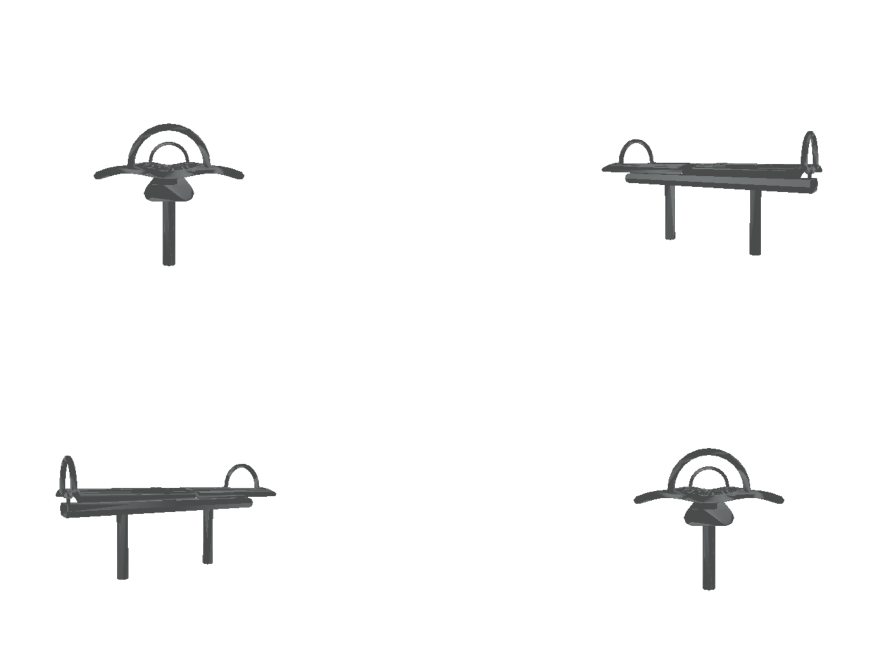

In [71]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

image_grid(torch.Tensor(renders).numpy(), rows=2, cols=2, rgb=True)
plt.show()